In [1]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
from mappings import *

In [2]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import re
from pyproj import Transformer
from datetime import date

In [3]:
update_storage_access()

environment = get_environment()

root_path = get_root_path()

bucket = environment["bucket"]

path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]

path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})



In [4]:
filename = '../data/PLEIADES/2022/GUYANE/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')

In [5]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = '973'
    )

In [6]:
from labeler import RILLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage

labeler_RIL = RILLabeler(date, '973')

In [7]:
import rasterio

In [8]:
mask_RIL = labeler_RIL.create_segmentation_label(image)

In [9]:
from labeler import BDTOPOLabeler

labeler_BDTOPO = BDTOPOLabeler(date, '973')

In [10]:
mask_BDTOPO = labeler_BDTOPO.create_segmentation_label(image)

In [11]:
import geopandas as gpd
from shapely.geometry import Polygon
from rasterio.features import rasterize, shapes

In [27]:
image_height = image.array.shape[1]
image_width = image.array.shape[2]
polygon_list = []
for shape in list(shapes(mask_BDTOPO)):
    polygon = Polygon(shape[0]["coordinates"][0])
    if polygon.area > 0.5 * image_height * image_width:
        continue
    polygon_list.append(polygon)
    
g_BDTOPO = gpd.GeoSeries(polygon_list)
# Créer un GeoDataFrame à partir de la liste de Polygon
gdf_BDTOPO = gpd.GeoDataFrame({'geometry': polygon_list})

In [29]:
polygon_list = []
for shape in list(shapes(mask_RIL)):
    polygon = Polygon(shape[0]["coordinates"][0])
    if polygon.area > 0.5 * image_height * image_width:
        continue
    polygon_list.append(polygon)
    
g_RIL = gpd.GeoSeries(polygon_list)
# Créer un GeoDataFrame à partir de la liste de Polygon
gdf_RIL = gpd.GeoDataFrame({'geometry': polygon_list})

In [30]:
result = gpd.sjoin(gdf_BDTOPO, gdf_RIL, op='contains')

/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [31]:
# Récupérer les géométries du résultat
geoms = result.values

In [32]:
polygon_result = []
for i in range(len(geoms)):
    polygon_result.append(geoms[i][0])
    

In [33]:
len(geoms)

24

In [34]:
# Créer un GeoDataFrame à partir des géométries
gdf_result = gpd.GeoDataFrame({'geometry': polygon_result})

In [35]:
g_result = gpd.GeoSeries(polygon_result)

In [36]:
clipped_g = gpd.clip(g_result, (0, 0, image_height, image_width))

new_label = [polygon.bounds for polygon in clipped_g]

In [37]:
from shapely.geometry import box
import geopandas as gpd

boxes = []
for bounding_coordinates in new_label:
    boxes.append(box(*bounding_coordinates))
g = gpd.GeoSeries(boxes)

In [38]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = '973'
    )
image.normalize()

<Axes: >

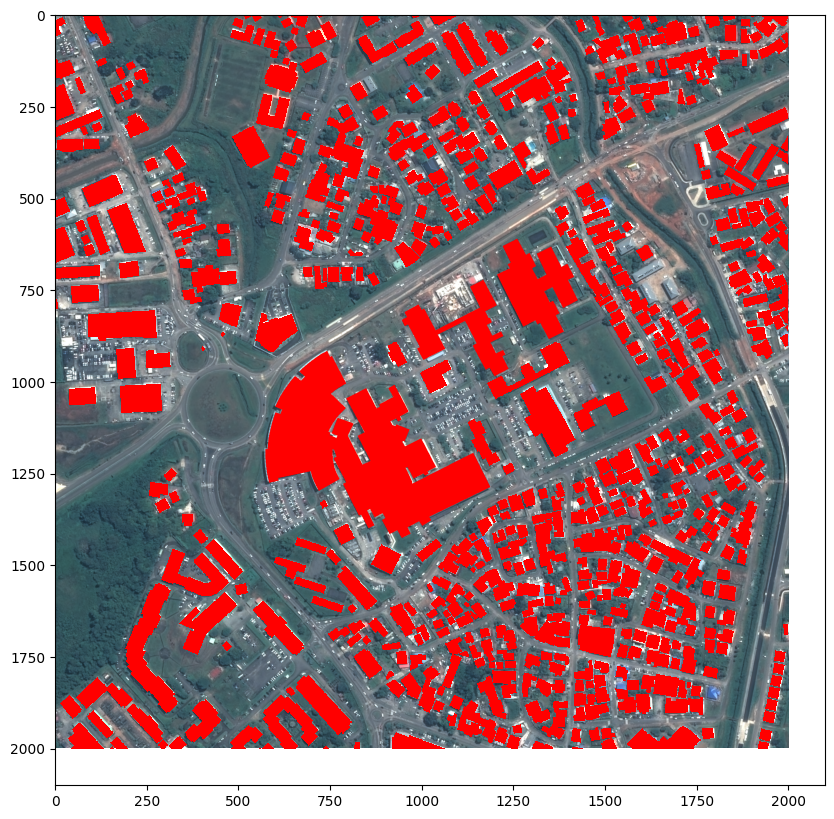

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
g_BDTOPO.plot(color="red", ax=ax)